In [1]:
#https://drive.google.com/file/d/1tswPPBqJDgJK-MyAezJPZsZJKSY285u1/view?usp=share_link
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

! gdown --id '1tswPPBqJDgJK-MyAezJPZsZJKSY285u1' --output ABIDE_csv.zip
!unzip "/content/ABIDE_csv.zip"

Sat May  6 10:14:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import torch
import os
import random
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
import nibabel as nib

import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
import torchvision.models as models
import copy

In [3]:
random.seed(3407)
rmb_label = {"ASD": 0, "TD": 1}      # 设置标签

class MultiModalDataset(Dataset):
    def __init__(self, data_dirho, data_diraal,data_direz , data_dircsv, transform=None):
        """ 
        ABIDE_db的Dataset
        :param data_dir: str, 数据集所在路径
        :param transform: torch.transform，数据预处理
        """
        self.label_name = {"ASD": 0, "TD": 1}
        self.data_infocsv = self.get_csv_info(data_dircsv)  # data_info存储所有txt路径和标签，在DataLoader中通过index读取样本
        self.data_infoez = self.get_1D_info(data_direz)  # data_info存储所有txt路径和标签，在DataLoader中通过index读取样本
        self.data_infoho = self.get_1D_info(data_dirho)
        self.data_infoaal = self.get_1D_info(data_diraal)

        self.transform = transform
        

        
    def __getitem__(self, index):
        path_csv, label_csv = self.data_infocsv[index]
        txt_data = np.loadtxt(path_csv, delimiter=',')
        label = label_csv
        csv = torch.from_numpy(txt_data).float().unsqueeze(0)
        ez = self.process_data(method='ez',index=index,labels=label_csv)
        ho = self.process_data(method='ho',index=index,labels=label_csv)
        aal = self.process_data(method='aal',index=index,labels=label_csv)

        if self.transform is not None:
            txt = 1   # 在这里做transform，转为tensor等等

        return ho,aal,ez,csv,label

    def __len__(self):
        return len(self.data_infocsv)

    @staticmethod
    def get_csv_info(data_dir):
        data_infocsv = list()
        for root, dirs, _ in os.walk(data_dir):
            # 遍历类别
            for sub_dir in dirs:
                txt_names = os.listdir(os.path.join(root, sub_dir))
                txt_names = list(filter(lambda x: x.endswith('.csv'), txt_names))

                # 遍历txt
                for i in range(len(txt_names)):
                    txt_name = txt_names[i]
                    path_txt = os.path.join(root, sub_dir, txt_name)
                    label = rmb_label[sub_dir]
                    data_infocsv.append((path_txt, int(label)))
                    data_infocsv = sorted(data_infocsv)

        return data_infocsv
    
    def get_1D_info(self,data_dir):
        data_infonii = list()
        for root, dirs, _ in os.walk(data_dir):
            # 遍历类别
            for sub_dir in dirs:
                txt_names = os.listdir(os.path.join(root, sub_dir))
                txt_names = list(filter(lambda x: x.endswith('.1D'), txt_names))

                # 遍历txt
                for i in range(len(txt_names)):
                    txt_name = txt_names[i]
                    path_txt = os.path.join(root, sub_dir, txt_name)
                    label = rmb_label[sub_dir]
                    data_infonii.append((path_txt, int(label)))
                    data_infonii = sorted(data_infonii)
        return data_infonii
    
    def process_data(self,method,index,labels):
        if method == 'ez':
            path, label = self.data_infoez[index]
            txt_data = np.loadtxt(path)
            cor = np.corrcoef(txt_data.T)
            cor = torch.from_numpy(cor).float().unsqueeze(0)
        if method == 'ho':
            path, label = self.data_infoho[index]
            txt_data = np.loadtxt(path)
            cor = np.corrcoef(txt_data.T)
            file1 = np.pad(cor, ((0, 5), (0, 5)), mode='constant')
            cor = torch.from_numpy(file1).float().unsqueeze(0)
        if method == 'aal':
            path, label = self.data_infoaal[index]
            txt_data = np.loadtxt(path)
            cor = np.corrcoef(txt_data.T)
            cor = torch.from_numpy(cor).float().unsqueeze(0)
        if labels != label:
            print('Error: label not match!')
            print('the error 1D:{}',path)
        
        
        return cor

In [4]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
 
        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)
 
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x): 
        # the shape of x is (b c h w)
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        attn = self.sigmoid(out) # (b c)
        attn = torch.squeeze(attn, dim=3)
        attn = torch.squeeze(attn, dim=2)
        x = x * attn[:, :, None, None]
        return x
    
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
 
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
 
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x): 
        # the shape of x is (b c h w)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attn = torch.cat([avg_out, max_out], dim=1)
        attn = self.conv1(attn) # b 1 h w
        attn = self.sigmoid(attn)
        attn = torch.squeeze(attn, dim=1) # b h w
        x = attn[:, None, :, :] * x
        return x

In [5]:
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 29 * 29, 128)

        # Add attention modules
        self.channel_attention2 = ChannelAttention(32)
        self.spatial_attention2 = SpatialAttention()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        
        # Apply channel attention and spatial attention after conv2
        x = self.channel_attention2(x)
        x = self.spatial_attention2(x)

        x = self.pool(x)
        x = x.view(-1, 32 * 29 * 29)
        x = F.relu(self.fc1(x))

        return x


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SelfAttention(nn.Module):
    def __init__(self, dim0=128): # dim0 should be the channel number of each input, i.e., x1, x2, x3,...
        super().__init__()
        self.attend = nn.Softmax(dim=-1)
        self.scale = dim0 ** -0.5

    def forward(self, x1, x2, x3, x4):
        # the shape of x1, x2, x3,... is (b 1 d)
        x = torch.cat((x1, x2, x3, x4), 1) # the shape of x is (b 4 d)
        dots = torch.matmul(x, x.transpose(-1, -2)) * self.scale
        attn = self.attend(dots) # the shape of x is (b, 4, 4)
        importance = torch.sum(attn, dim=1) # the shape of importance is (b, 4)
        importance = self.attend(importance)
        x = x * importance[:, :, None]
        x = x.view(x.shape[0], -1) # this can be sended into your classifer
        return x

In [7]:
class MultiModalClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(MultiModalClassifier, self).__init__()
        self.feature_extractor_ho = FeatureExtractorCNN()
        self.feature_extractor_aal = FeatureExtractorCNN()
        self.feature_extractor_ez = FeatureExtractorCNN()
        self.feature_extractor_csv = FeatureExtractorCNN()

        # Add the self attention layer
        self.self_attention = SelfAttention()

        # Fully connected layer to combine the features from both extractors and perform classification
        self.classifier = nn.Sequential(
            nn.Linear(128*4, 256),  # Adjust the input size to match the output of the self attention layer
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self,x_csv,x_ho,x_ez,x_aal):
        features_csv = self.feature_extractor_csv(x_csv)
        features_ho = self.feature_extractor_ho(x_ho)
        features_ez = self.feature_extractor_ez(x_ez)
        features_aal = self.feature_extractor_aal(x_aal)

        # Apply self attention on the features
        combined_features = self.self_attention(features_ho.unsqueeze(1), features_ez.unsqueeze(1), features_aal.unsqueeze(1), features_csv.unsqueeze(1))

        # Pass the combined features through the classifier
        output = self.classifier(combined_features)
        return output


In [8]:
csv_split_dir = os.path.join('/content//csv_split')  
csv_train_dir = os.path.join(csv_split_dir, "train")
csv_valid_dir = os.path.join(csv_split_dir, "valid")
csv_test_dir  = os.path.join(csv_split_dir, "test") 
aal_split_dir = os.path.join('/content//aal_split')  
aal_train_dir = os.path.join(aal_split_dir, "train")
aal_valid_dir = os.path.join(aal_split_dir, "valid")
aal_test_dir  = os.path.join(aal_split_dir, "test") 
ho_split_dir = os.path.join('/content//rho_split')  
ho_train_dir = os.path.join(ho_split_dir, "train")
ho_valid_dir = os.path.join(ho_split_dir, "valid")
ho_test_dir  = os.path.join(ho_split_dir, "test") 
ez_split_dir = os.path.join('/content//ez_split')  
ez_train_dir = os.path.join(ez_split_dir, "train")
ez_valid_dir = os.path.join(ez_split_dir, "valid")
ez_test_dir  = os.path.join(ez_split_dir, "test") 

MultiModalClassifier(
  (feature_extractor_ho): FeatureExtractorCNN(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=26912, out_features=128, bias=True)
    (channel_attention2): ChannelAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (fc1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu1): ReLU()
      (fc2): Conv2d(2, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (sigmoid): Sigmoid()
    )
    (spatial_attention2): SpatialAttention(
      (conv1): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (sigmoid): Sigmoid()
    )
  )
  (feature_extractor_aal): FeatureExtractorCNN(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), strid

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c5d7fdbd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connectio

Epoch [90/100], Train Loss: 0.0025, Train Accuracy: 1.0000, Validation Loss: 1.7314, Validation Accuracy: 0.7000
Early stopping triggered.


Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


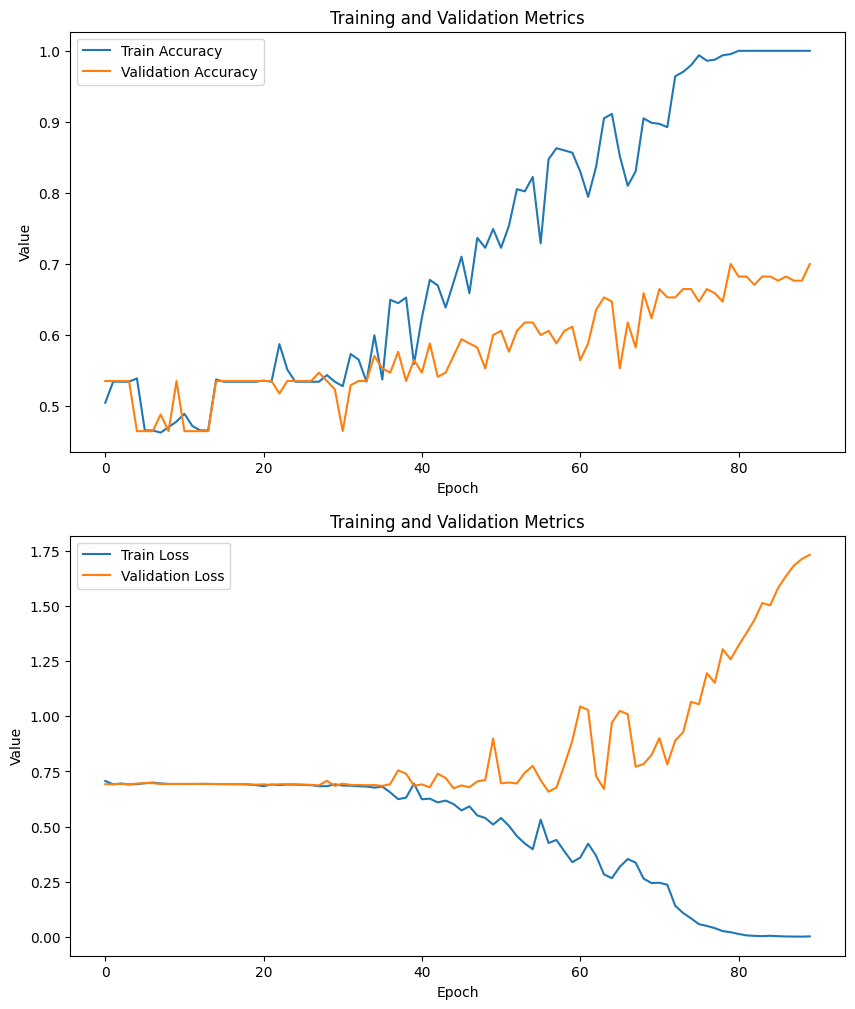

Bestloss


TypeError: ignored

In [12]:
# 定义超参数
input_size = [116,116]
batch_size = 128
learning_rate = 0.001
num_epochs = 100
num_classes = 2
log_interval = 8
val_interval = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalClassifier()
model = model.to(device)
# print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # 设置学习率下降策略

# 实例化数据集和数据加载器

train_dataset = MultiModalDataset(ho_train_dir,aal_train_dir,ez_train_dir,csv_train_dir, transform=None)
valid_dataset = MultiModalDataset(ho_valid_dir,aal_valid_dir,ez_valid_dir,csv_valid_dir, transform=None)
test_dataset = MultiModalDataset(ho_test_dir,aal_test_dir,ez_test_dir,csv_test_dir, transform=None)
#CNN 图像模型dataloader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn = collate_fn,num_workers = num_workers)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,collate_fn = collate_fn,num_workers = num_workers)
#非CNN 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers = 8)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,num_workers =2)

print('训练')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
best_val_loss = float('inf')
best_val_acc = 0.0
loss_patience = 10
acc_patience = 10
loss_count = 0
acc_count = 0
model_bestloss = None
model_bestacc = None
# ============================ step 5/5 训练 ============================
# 训练和验证
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (ho,aal,ez,csv,label) in enumerate(train_loader):
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device),csv.to(device),label.to(device)
        optimizer.zero_grad()
        outputs = model(ho, aal, ez, csv)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * csv.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 验证阶段
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for ho,aal,ez,csv,label in valid_loader:
            ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device),csv.to(device),label.to(device)
            outputs = model(ho, aal, ez, csv)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * csv.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == labels).sum().item()
            # pred = outputs.argmax(dim=1)
            # print(f"Sample: predicted={pred.item()}, target={label.item()},matched?={label.item() == pred.item()}")

    valid_loss = running_loss / len(valid_dataset)
    valid_acc = correct / total
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    # 打印训练过程中的指标
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")
    # 保存模型
    if epoch > 40 :
      if valid_loss < best_val_loss:
          best_val_loss = valid_loss
          model_bestloss = copy.deepcopy(model)
          loss_count = 0
      else:
          loss_count += 1

      if valid_acc > best_val_acc:
          best_val_acc = valid_acc
          model_bestacc = copy.deepcopy(model)
          acc_count = 0
      else:
          acc_count += 1

      # 如果损失连续增加，且准确率不再增加，则停止训练
      if loss_count >= loss_patience and acc_count >= acc_patience:
          print("Early stopping triggered.")
          break

# 保存最佳模型
torch.save(model_bestacc.state_dict(), 'accmodel_2attention.pth')
torch.save(model_bestloss.state_dict(), 'lossmodel_2attention.pth')


# 绘制训练和验证指标的图表
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs[0].plot(train_accs, label='Train Accuracy')
axs[0].plot(valid_accs, label='Validation Accuracy')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Value')
axs[0].set_title('Training and Validation Metrics')

axs[1].plot(train_losses, label='Train Loss')
axs[1].plot(valid_losses, label='Validation Loss')
axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Value')
axs[1].set_title('Training and Validation Metrics')

plt.show()

# 在测试阶段，我们需要跟踪的指标
TP = 0
TN = 0
FP = 0
FN = 0
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 开始测试
print('Bestloss')
model_bestloss.eval()
with torch.no_grad():
    for ho, aal, ez, csv, label in test_loader:
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device), csv.to(device), label.to(device)
        outputs = model(aal)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(labels)):
            true_label = labels[i]
            pred_label = predicted[i]
            if true_label == 1 and pred_label == 1:
                TP += 1
            elif true_label == 0 and pred_label == 0:
                TN += 1
            elif true_label == 0 and pred_label == 1:
                FP += 1
            elif true_label == 1 and pred_label == 0:
                FN += 1

# 计算各项指标
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")

print('\nBestacc')
TP = 0
TN = 0
FP = 0
FN = 0
model_bestacc.eval()
with torch.no_grad():
    for ho, aal, ez, csv, label in test_loader:
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device), csv.to(device), label.to(device)
        outputs = model(aal)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(labels)):
            true_label = labels[i]
            pred_label = predicted[i]
            if true_label == 1 and pred_label == 1:
                TP += 1
            elif true_label == 0 and pred_label == 0:
                TN += 1
            elif true_label == 0 and pred_label == 1:
                FP += 1
            elif true_label == 1 and pred_label == 0:
                FN += 1

# 计算各项指标
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")

In [13]:

# 在测试阶段，我们需要跟踪的指标
TP = 0
TN = 0
FP = 0
FN = 0
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 开始测试
print('Bestloss')
model_bestloss.eval()
with torch.no_grad():
    for ho, aal, ez, csv, label in test_loader:
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device), csv.to(device), label.to(device)
        outputs = model(ho, aal, ez, csv)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(labels)):
            true_label = labels[i]
            pred_label = predicted[i]
            if true_label == 1 and pred_label == 1:
                TP += 1
            elif true_label == 0 and pred_label == 0:
                TN += 1
            elif true_label == 0 and pred_label == 1:
                FP += 1
            elif true_label == 1 and pred_label == 0:
                FN += 1

# 计算各项指标
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")

print('\nBestacc')
TP = 0
TN = 0
FP = 0
FN = 0
model_bestacc.eval()
with torch.no_grad():
    for ho, aal, ez, csv, label in test_loader:
        ho, aal, ez, csv, labels = ho.to(device), aal.to(device), ez.to(device), csv.to(device), label.to(device)
        outputs = model(ho, aal, ez, csv)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(labels)):
            true_label = labels[i]
            pred_label = predicted[i]
            if true_label == 1 and pred_label == 1:
                TP += 1
            elif true_label == 0 and pred_label == 0:
                TN += 1
            elif true_label == 0 and pred_label == 1:
                FP += 1
            elif true_label == 1 and pred_label == 0:
                FN += 1

# 计算各项指标
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")

Bestloss
Accuracy: 0.7093
Sensitivity: 0.6522
Specificity: 0.7750
Positive Predictive Value: 0.7692
Negative Predictive Value: 0.6596

Bestacc
Accuracy: 0.7093
Sensitivity: 0.6522
Specificity: 0.7750
Positive Predictive Value: 0.7692
